In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from collections import deque
from tqdm import tqdm  
import pandas as pd
import copy
from IPython.display import clear_output


In [2]:
#ss=0,se=1,sd=2
P_0_matrix=np.array([[0.0,0.0,1.0],
                   [0.0,0.0,1.0],
                   [0.0,0.0,1.0]])

P_0_matrix


array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [3]:
#x=0 --> reliable, x=1 --> greedy
def P_1_matrix(x):
    if x==0:
        P_1_matrix=np.array([[0.0,1.0,0.0],
                        [0.0,1.0,0.0],
                        [0.0,0.0,1.0]])
    else:
        P_1_matrix=np.array([[0.0,1.0,0.0],
                        [0.0,0.0,1.0],
                        [0.0,0.0,1.0]])

    return P_1_matrix

In [4]:
P_1_matrix(0)

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [5]:
#reward_epsilon=0.1
def reward_matrix(x):
    if x==0:
        reward_matrix=[[0,0],[0.9,0.9],[0,0]]
    else:
        reward_matrix=[[0,0],[1.0,1.0],[0,0]]
    return reward_matrix

In [6]:
action_space=[0,1]
state_space=[0,1,2]
N=20
M=10
epsilon=0.1
subsidy=0
arm_indexes=[i for i in range(N)]
gamma=0.99999

In [7]:
def step(state,state_space,action,P_0_matrix,P_1_matrix,reward_matrix):
  new_state=state
  if(action==1):
    new_state=np.random.choice(state_space,replace=True,p=P_1_matrix[state])
    reward=reward_matrix[state][1]
  else:
    new_state=np.random.choice(state_space,replace=True,p=P_0_matrix[state])
    reward=reward_matrix[state][0]
  return [new_state,reward]

In [8]:
def act(Q_values,epsilon,state,arm_type):
    decision=np.random.binomial(n=1,p=epsilon,size=1)
    if decision==1:
        action=random.choice([0,1])
    else:
        action=np.argmax(Q_values[arm_type][state])
    return action

In [9]:
def Q_value_update(Q_values,state,next_state,action,reward,arm_type,subsidy,alpha):
    arm_index=arm_type
    if action==1:
        Q_values[arm_index][state][action]=(1-alpha)*(Q_values[arm_index][state][action])+alpha*(reward+max(Q_values[arm_index][next_state])-(np.array(Q_values[arm_index]).sum())/6)
    else:
        Q_values[arm_index][state][action]=(1-alpha)*(Q_values[arm_index][state][action])+alpha*(reward+subsidy+max(Q_values[arm_index][next_state])-(np.array(Q_values[arm_index]).sum())/6)

In [10]:
Q_values=[]
for i in range(0,2):
  Q_values.append(reward_matrix(i))
  
Q_values

[[[0, 0], [0.9, 0.9], [0, 0]], [[0, 0], [1.0, 1.0], [0, 0]]]

In [11]:
rewards=[]
subsidies=[]
action_sums=[]
betas=[]
alphas=[]
epsilon=1
epsilons=[]
beta=0

In [12]:
alternative_indexes=[0 for _ in range(N)]
current_state=[0 for _ in range(N)]

In [13]:
for i in range(1,500001):
  # top_M_indices=act(alternative_indexes,N,M,epsilon)
  action_sum=0
  reward_sum=0
  action_flag=0
  alpha=1/(1+(i/5000))
  if i%50==0:
    beta=1/(1+(i*np.log(i)/5000))

  for index in arm_indexes:
      if index<=N/2:
          action=act(Q_values,epsilon,current_state[index],0)
          action_sum+=action
          x=step(current_state[index],state_space,action,P_0_matrix,P_1_matrix(0),reward_matrix(0))
          new_state=x[0]
          reward=x[1]
          Q_value_update(Q_values,current_state[index],new_state,action,reward,0,subsidy,alpha)
          current_state[index]=new_state
          reward_sum+=reward
      
      else:
          action=act(Q_values,epsilon,current_state[index],1)
          action_sum+=action
          x=step(current_state[index],state_space,action,P_0_matrix,P_1_matrix(1),reward_matrix(1))
          new_state=x[0]
          reward=x[1]
          Q_value_update(Q_values,current_state[index],new_state,action,reward,1,subsidy,alpha)
          current_state[index]=new_state
          reward_sum+=reward
         

      #print(x)
  # print(i)
  #print(reward_sum)

  subsidy+=beta*(action_sum-M)
  subsidies.append(subsidy)
  
  epsilon=epsilon*gamma

  # if epsilon<=0.01:
  #   epsilon=0.01
  rewards.append(reward_sum)
  action_sums.append(action_sum)
  betas.append(beta)
  alphas.append(alpha)
  clear_output(wait=True)
  epsilons.append(epsilon)





In [14]:
epsilon

0.006737778551546669

Text(0.5, 1.0, 'Subsidy vs Steps for Health Worker Example')

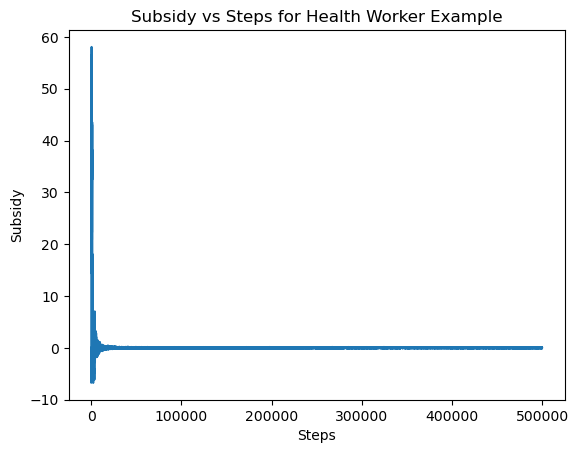

In [15]:
plt.plot(subsidies)
plt.xlabel('Steps')
plt.ylabel('Subsidy')
plt.title('Subsidy vs Steps for Health Worker Example')

In [16]:
df=pd.DataFrame(rewards)


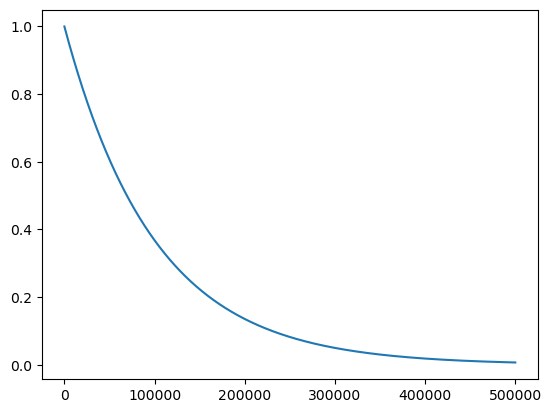

In [17]:
plt.plot(epsilons)

Text(0.5, 1.0, ' Moving Average of reward for Health Worker Example ')

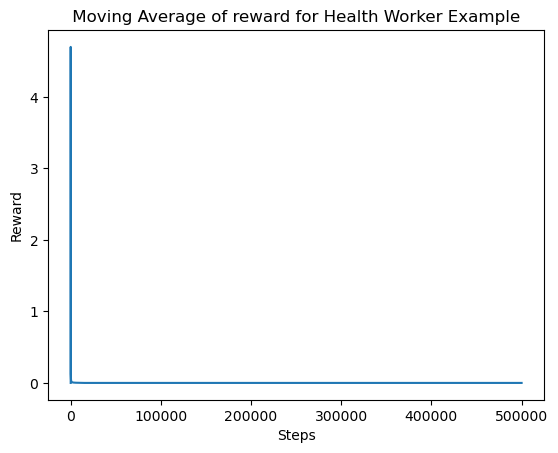

In [18]:
plt.plot(df[0].rolling(10000,min_periods=1).mean())
# plt.axhline(y = 14, color = 'r', linestyle = '-') 
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.title(' Moving Average of reward for Health Worker Example ')


Text(0.5, 1.0, ' Moving Average of number of arms activated for Health Worker Example ')

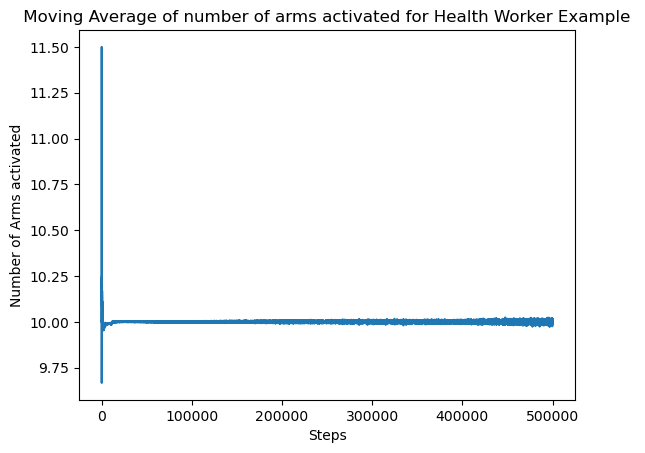

In [19]:
df['action_sums']=action_sums
plt.plot(df['action_sums'].rolling(10000,min_periods=1).mean())
plt.xlabel('Steps')
plt.ylabel('Number of Arms activated')
plt.title(' Moving Average of number of arms activated for Health Worker Example ')


In [20]:
current_state_init=[1 for _ in range(int(N/2))]
current_state_init.extend([0 for _ in range(int(N-int(N/2)))])
# current_state_init.extend(current_state_init)
print(current_state_init)


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [21]:
reward_sums_alt_index=[]
alternative_indexes=[0 for _ in range(N)]
current_state=copy.deepcopy(current_state_init)
for i in range(1,100001):
  reward_sum_alt_index=0
  for index in arm_indexes:
    if index<N/2:
        alternative_indexes[index]=Q_values[0][current_state[index]][1]-Q_values[0][current_state[index]][0]
    else:
        alternative_indexes[index]=Q_values[1][current_state[index]][1]-Q_values[1][current_state[index]][0]
  indices_to_pull = sorted(range(len(alternative_indexes)), key = lambda j: alternative_indexes[j])[-M:]
  # print(indices_to_pull)
  for index in arm_indexes:
    if index in indices_to_pull:
      if index<N/2:
        x=step(current_state[index],state_space,1,P_0_matrix,P_1_matrix(0),reward_matrix((0)))
      else:
        x=step(current_state[index],state_space,1,P_0_matrix,P_1_matrix(1),reward_matrix((1)))
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_alt_index+=reward
    else:
      if index<N/2:
        x=step(current_state[index],state_space,0,P_0_matrix,P_1_matrix(0),reward_matrix((0)))
      else:
        x=step(current_state[index],state_space,0,P_0_matrix,P_1_matrix(1),reward_matrix((1)))
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_alt_index+=reward
  reward_sums_alt_index.append(reward_sum_alt_index)

In [22]:
current_state

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [23]:
whittle_indexes=[[0.9,0.9,0],[1,0,0]]

In [24]:
whittle_indexes[1][0]

1

In [25]:
reward_sums_whittle_index=[]
whittle_index_arms=[0 for _ in range(N)]
current_state=copy.deepcopy(current_state_init)
for i in range(1,100001):
  reward_sum_whittle_index=0
  for index in arm_indexes:
    if index<N/2:
      whittle_index_arms[index]=whittle_indexes[0][current_state[index]]
    else:
      whittle_index_arms[index]=whittle_indexes[1][current_state[index]]
  
  indices_to_pull = sorted(range(len(whittle_index_arms)), key = lambda j: whittle_index_arms[j])[-M:]
  # print(indices_to_pull)
  for index in arm_indexes:
    if index in indices_to_pull:
      if index<N/2:
        x=step(current_state[index],state_space,1,P_0_matrix,P_1_matrix(0),reward_matrix((0)))
      else:
        x=step(current_state[index],state_space,1,P_0_matrix,P_1_matrix(1),reward_matrix((1)))
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_whittle_index+=reward
    else:
      if index<N/2:
        x=step(current_state[index],state_space,0,P_0_matrix,P_1_matrix(0),reward_matrix((0)))
      else:
        x=step(current_state[index],state_space,0,P_0_matrix,P_1_matrix(1),reward_matrix((1)))
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_whittle_index+=reward
  reward_sums_whittle_index.append(reward_sum_whittle_index)

In [26]:
current_state

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [27]:
whittle_index_arms

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [28]:
indices_to_pull

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

Text(0.5, 1.0, ' Moving Average of reward for Health Worker Example ')

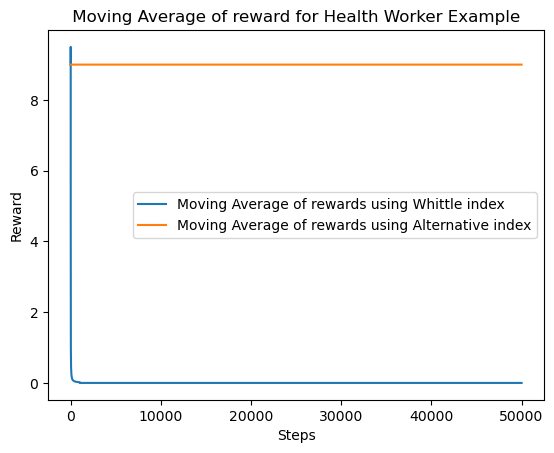

In [29]:
df=pd.DataFrame()
df['reward_whittle']=reward_sums_whittle_index
df['reward_alternate']=reward_sums_alt_index

plt.plot(df['reward_whittle'][:50000].rolling(1000,min_periods=1).mean(),label='Moving Average of rewards using Whittle index')
plt.plot(df['reward_alternate'][:50000].rolling(1000,min_periods=1).mean(),label='Moving Average of rewards using Alternative index')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.legend()
plt.title(' Moving Average of reward for Health Worker Example ')

Text(0.5, 1.0, ' Moving Average of reward for Restart Example ')

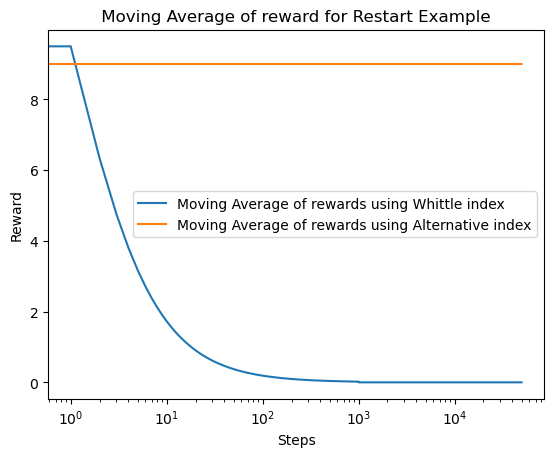

In [36]:
x=[ i for i in range(50000)]
plt.semilogx(x,df['reward_whittle'][:50000].rolling(1000,min_periods=1).mean(),label='Moving Average of rewards using Whittle index')
plt.semilogx(x,df['reward_alternate'][:50000].rolling(1000,min_periods=1).mean(),label='Moving Average of rewards using Alternative index')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.legend()
plt.title(' Moving Average of reward for Restart Example ')

In [30]:
alternative_indexes

[7.042566937535357,
 7.042566937535357,
 7.042566937535357,
 7.042566937535357,
 7.042566937535357,
 7.042566937535357,
 7.042566937535357,
 7.042566937535357,
 7.042566937535357,
 7.042566937535357,
 9.707938583047859e-05,
 9.707938583047859e-05,
 9.707938583047859e-05,
 9.707938583047859e-05,
 9.707938583047859e-05,
 9.707938583047859e-05,
 9.707938583047859e-05,
 9.707938583047859e-05,
 9.707938583047859e-05,
 9.707938583047859e-05]

In [31]:
current_state

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [32]:
Q_values

[[[-0.3374911665494676, 0.5625208058894571],
  [-1.4370988854395887, 5.605468052095768],
  [-2.196643483529258, -2.1965732548852976]],
 [[-0.3753053918738802, 0.6278706380653664],
  [0.5451667439097739, 0.5495482756396445],
  [-0.6671297091671168, -0.6670326297812863]]]

In [33]:
step(2,state_space,1,P_0_matrix,P_1_matrix(0),reward_matrix((0)))

[2, 0]